# Odudarajući podaci

Prisustvo odudarajućih podataka (engl. outliers) vrlo utiče na formu rešenja modela linearne regresije. Sledeći primer to ilustruje.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn import linear_model
from sklearn import metrics

In [3]:
np.random.seed(7)

Skup podataka koji ćemo generisati imaće ukupno 49 instanci. Veza između nezavisne i zavisne promenljive će biti oblika $y=3+2x$ uz dodatak šuma iz normalne raspodele. 

In [4]:
N = 49
x = np.random.randn(N)
y = 3 + 2 * x + np.random.randn(N)

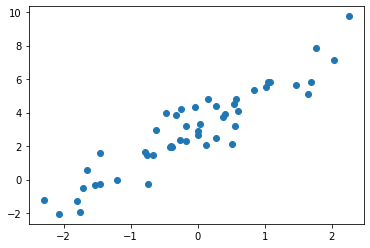

In [5]:
plt.scatter(x, y)
plt.show()

Dalje ćemo odrediti i grafički prikazati model linearne regresije koji aproksimira ovaj skup tačaka.

In [6]:
model = linear_model.LinearRegression()
model.fit(x.reshape(-1, 1), y)
beta0, beta1 = model.intercept_, model.coef_[0]

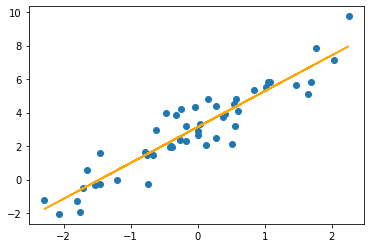

In [7]:
plt.scatter(x, y)
plt.plot(x, beta0 + beta1 * x, color='orange')
plt.show()

U naš skup ubacićemo na slučajan način nekoliko odudarajućih podataka. Broj odudarajućih podataka će biti predstavljan parametrom $k$.

In [8]:
k = 4
outlier_indexes = np.random.choice(np.arange(0, N), k)

Za izdvojene instance ćemo udvostručiti vrednost ciljne promenljive.

In [9]:
y_with_outliers = y.copy()
y_with_outliers[outlier_indexes] *= 2

Potom ćemo nad novim skupom odredi i grafički prikazati model linearne regresije.

In [10]:
model_with_outliers = linear_model.LinearRegression()
model_with_outliers.fit(x.reshape(-1, 1), y_with_outliers)
beta0_with_outliers, beta1_with_outliers = model_with_outliers.intercept_, model_with_outliers.coef_[0]

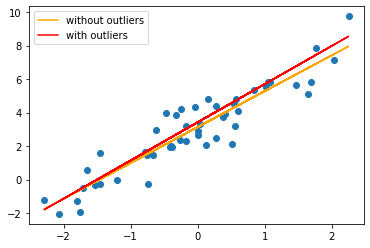

In [11]:
plt.scatter(x, y)
plt.plot(x, beta0 + beta1*x, color='orange', label='without outliers')
plt.plot(x, beta0_with_outliers + beta1_with_outliers*x, color='red', label='with outliers')
plt.legend(loc='best')
plt.show()

Kao što možemo da vidimo, prisustvo odudarajućih podataka je uticalo na promenu koeficijenata modela. Veće vrednosti odudarajućih podataka bi još više uticale na ovu promenu. 

Dalje ćemo upoznati neke tehnike detekcije i eliminacije odudarajućih podataka.

Jedan od načina da se ispita postojanje odudarajućih podataka je iscrtavanje skupa vrednosti u formi grafika-kutije (eng. boxplot). Ovaj grafik koristi medijanu skupa vrednosti (Q2), donji (Q1) i gornji (Q3) kvartil i na osnovu njih izračunava dopustive donje i gornje vrednosti podataka. Vrednosti koje prevazilaze ove opsege se mogu smatrati odudarajućim vrednostima. 

<img src='assets/boxplot.png'>

Podesetimo se, kvartili dele distribuciju na četiri jednaka dela tako da svaki deo sadrži četvrtinu rezultata distribucije. Tako je `medijana` vrednost koja (sortirani) skup vrednosti deli na dva jednaka dela, `donji kvartil` je vrednost koja ograničava prvu četvrtinu skupa vrednosti, a `gornji kvartil` vrednost koja ograničava tri četvrtine skupa vrednosti. 

Za iscrtavanje grafika kutije, može se iskoristiti boxplot funkcija `matplotlib` biblioteke (ili istoimena funkcija `pandas` biblioteke).

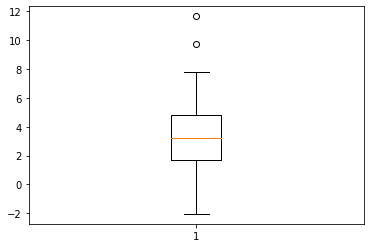

In [12]:
plt.boxplot(y_with_outliers)
plt.show()

Sa grafika možemo videti da se dve vrednosti u skupu smatraju odudarajućima.

Dalje ćemo računski odrediti gornje i donje dopustive opsege za vrednosti ciljne promenljive. 

Određujemo redom medijanu, donji i gornji kvartil. Za računanje medijane iskoristićemo funkciju `median`, a za računanje kvartila funkciju `quantile`. Za računanje kvartila može se koristiti i funkcija `percentile` - jedina razlika je u tome što se vrednosti zadaju na skali od 0 do 100 umesto na skali od 0 do 1.

In [13]:
Q2 = np.median(y_with_outliers)
print('Q2: ', Q2)

Q2:  3.188772317273629


In [14]:
Q1 = np.quantile(y_with_outliers, 0.25)
print('Q1: ', Q1)

Q1:  1.6747316783038404


In [15]:
Q3 = np.quantile(y_with_outliers, 0.75)
print('Q3: ', Q3)

Q3:  4.81275276421185


Zatim određujemo interkvartilni opseg:

In [16]:
IQR = Q3 - Q1 
print('IQR: ', IQR)

IQR:  3.1380210859080098


I na kraju, dopistive donje i gornje granice:

In [17]:
lower_limit = Q1 - 1.5*IQR
print('Donja granica: ', lower_limit)

Donja granica:  -3.0322999505581745


In [18]:
upper_limit = Q3 + 1.5*IQR
print('Gornja granica: ', upper_limit)

Gornja granica:  9.519784393073865


Ostalo je još da izdvojimo vrednosti koje smatramo odudarajućim podacima, kao i njihove indekse zarad daljeg ispitivanja i potencijalnog brisanja iz skupa.

In [19]:
outliers_below_lower_limit = y_with_outliers[y_with_outliers < lower_limit]

In [20]:
outliers_below_lower_limit

array([], dtype=float64)

In [21]:
outliers_above_upper_limit = y_with_outliers[y_with_outliers > upper_limit]

In [22]:
outliers_above_upper_limit

array([11.66763937,  9.75513709])

In [23]:
outliers_above_upper_limit_indexes = np.where(y_with_outliers > upper_limit)

In [24]:
outliers_above_upper_limit_indexes

(array([28, 47]),)

Sve odudarajuće vrednosti možemo dobiti nadovezivanjem gore izdvojenih vrednosti. Za nadovezivanje nizova se koristi funkcija `concat`. Alternativno se mogao koristi uslov disjunkcije koji pronalazi sve odudarajuće vrednosti odjednom.

In [25]:
all_outliers = np.concatenate((outliers_below_lower_limit, outliers_above_upper_limit), axis = 0)

In [26]:
print('All outliers: ', all_outliers )

All outliers:  [11.66763937  9.75513709]


Dalje ćemo na jednom realnom skupu podataka koji sumira statistike u vezi sa kvalitetom vina izdvojiti nekoliko atributa i ispitati njihove odudarajuće vrednosti.

Prvo ćemo učitati skup podataka `winequality-red.csv` i upoznati njegove atribute.

In [27]:
data = pd.read_csv('data/winequality-red.csv', sep=';')

In [28]:
data.head(7)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5


Atribut `pH`, kako samo ime kaže, oslikava PH vrednost vina. Ovaj atribut ima normalnu raspodelu.

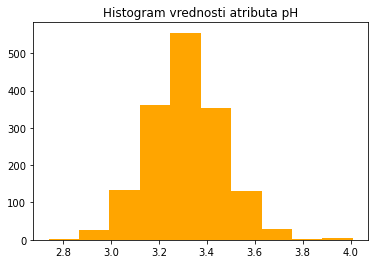

In [29]:
plt.title('Histogram vrednosti atributa pH')
plt.hist(data['pH'], color='orange')
plt.show()

Atribut `fixed acidity` označava kiselost vina. 

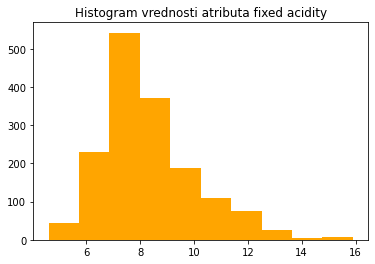

In [30]:
plt.title('Histogram vrednosti atributa fixed acidity')
plt.hist(data['fixed acidity'], color='orange')
plt.show()

Ukoliko promenljiva ima normalnu raspodelu, odudarajući podaci se mogu tražiti i u pojasima koji su veći od tri standardne devijacije.

<img src='assets/normal_distribution_outliers.png'>

Sledećim blokom koda možemo pronaći takve podatke. Za računanje srednje vrednosti raspodele možemo koristiti funkciju `mean`, a za računanje standardne devijacije funkciju `std`.

In [31]:
ph_mean = data['pH'].mean()

In [32]:
ph_std = data['pH'].std()

In [33]:
ph_lower_limit = ph_mean - 3*ph_std
ph_upper_limit = ph_mean + 3*ph_std

In [34]:
data[(data['pH'] < ph_lower_limit) | (data['pH'] > ph_upper_limit)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
45,4.6,0.520,0.15,2.10,0.054,8.0,65.0,0.99340,3.90,0.56,13.1,4
95,4.7,0.600,0.17,2.30,0.058,17.0,106.0,0.99320,3.85,0.60,12.9,6
151,9.2,0.520,1.00,3.40,0.610,32.0,69.0,0.99960,2.74,2.00,9.4,4
695,5.1,0.470,0.02,1.30,0.034,18.0,44.0,0.99210,3.90,0.62,12.8,6
1111,5.4,0.420,0.27,2.00,0.092,23.0,55.0,0.99471,3.78,0.64,12.3,7
1300,5.2,0.645,0.00,2.15,0.080,15.0,28.0,0.99444,3.78,0.61,12.5,6
1316,5.4,0.740,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5,6
1321,5.0,0.740,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5,6


Tehnikom analize interkvartilnih opsega možemo doći do sledećih rezultata za atribut `fixed acidity`. Ova tehnika je podesna kada je raspodela takva da je jedan rep duži od drugog (engl. `skewed` distribution).

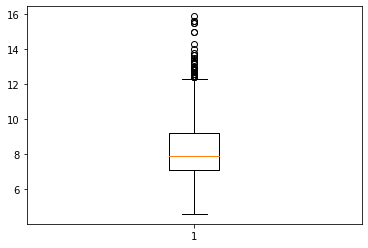

In [35]:
plt.boxplot(data['fixed acidity'])
plt.show()

In [36]:
fa_quantile_25 = data['fixed acidity'].quantile(0.25)
fa_quantile_75 = data['fixed acidity'].quantile(0.75)
fa_IQR = fa_quantile_75 - fa_quantile_25

In [37]:
fa_lower_limit = fa_quantile_25 - 1.5*fa_IQR
fa_upper_limit = fa_quantile_75 + 1.5*fa_IQR

In [38]:
data[(data['fixed acidity'] < fa_lower_limit) | (data['fixed acidity'] > fa_upper_limit)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
205,12.8,0.300,0.74,2.6,0.095,9.0,28.0,0.99940,3.20,0.77,10.8,7
206,12.8,0.300,0.74,2.6,0.095,9.0,28.0,0.99940,3.20,0.77,10.8,7
243,15.0,0.210,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7
244,15.0,0.210,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7
264,12.5,0.560,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9,5
294,13.3,0.340,0.52,3.2,0.094,17.0,53.0,1.00140,3.05,0.81,9.5,6
328,13.4,0.270,0.62,2.6,0.082,6.0,21.0,1.00020,3.16,0.67,9.7,6
338,12.4,0.490,0.58,3.0,0.103,28.0,99.0,1.00080,3.16,1.00,11.5,6
339,12.5,0.280,0.54,2.3,0.082,12.0,29.0,0.99970,3.11,1.36,9.8,7
347,13.8,0.490,0.67,3.0,0.093,6.0,15.0,0.99860,3.02,0.93,12.0,6


Nakon izdvajanja odudarajućih podataka, pitanje je šta uraditi sa njima. Ukoliko veličina skupa dozvoljava, podatke je moguće obrisati. Za brisanje podataka koji se čuvaju u strukturi DataFrame se može koristiti funkcija `drop`.

In [39]:
data.shape

(1599, 12)

In [40]:
rows_to_delete = data[(data['pH'] < ph_lower_limit) | (data['pH'] > ph_upper_limit)].index

In [41]:
data_with_no_outliers = data.drop(index=rows_to_delete, axis=0)

In [42]:
data_with_no_outliers.shape

(1591, 12)

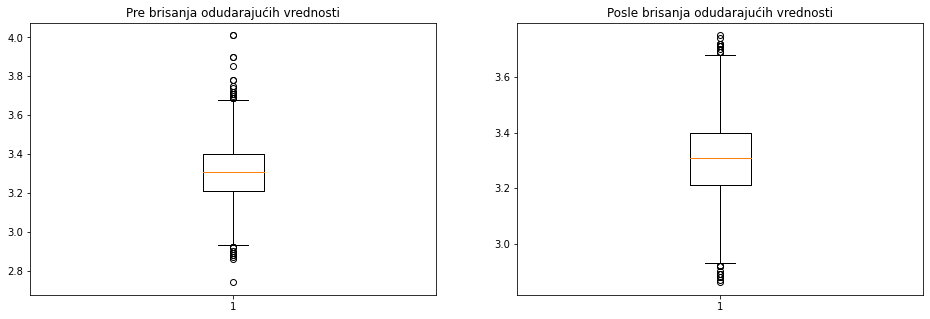

In [43]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.boxplot(data['pH'])
plt.title('Pre brisanja odudarajućih vrednosti')

plt.subplot(1,2,2)
plt.boxplot(data_with_no_outliers['pH'])
plt.title('Posle brisanja odudarajućih vrednosti')

plt.show()

Osim brisanja, odudarajuće vrednosti koje se nalaze iznad gornje granice je moguće zameniti maksimalnim dozvoljenim, i slično, vrednosti odudarajućih podataka koje se nalaze ispod donje granice je moguće zameniti minimalnim dozvoljenim. Ova tehnika se naziva limitiranje (engl. capping). 

In [44]:
limited_data = data.copy()
limited_data['fixed acidity'] = np.where(limited_data['fixed acidity'] > fa_upper_limit, fa_upper_limit, limited_data['fixed acidity'])
limited_data['fixed acidity'] = np.where(limited_data['fixed acidity'] < fa_lower_limit, fa_lower_limit, limited_data['fixed acidity'])

Nakon limitiranja, možemo prikazati grafikone pre i posle obrade odudarajućih vrednosti.

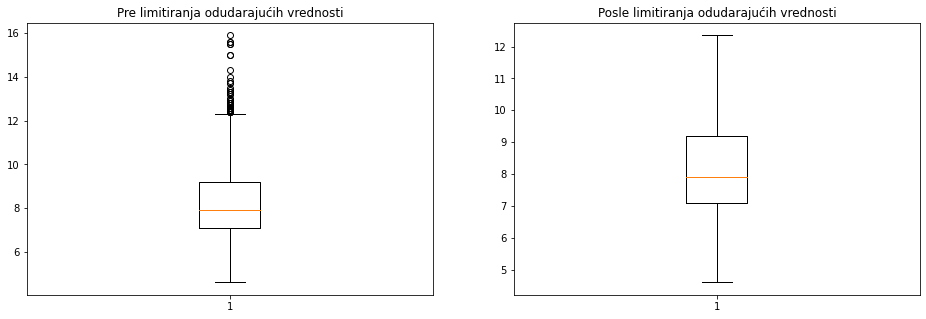

In [45]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.boxplot(data['fixed acidity'])
plt.title('Pre limitiranja odudarajućih vrednosti')

plt.subplot(1,2,2)
plt.boxplot(limited_data['fixed acidity'])
plt.title('Posle limitiranja odudarajućih vrednosti')

plt.show()

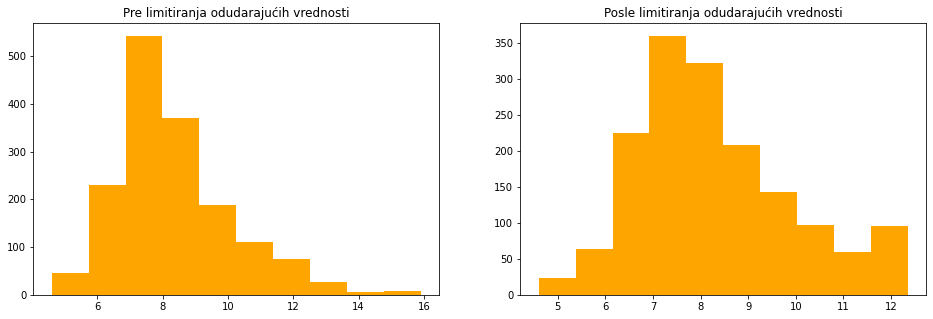

In [46]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.hist(data['fixed acidity'], color='orange')
plt.title('Pre limitiranja odudarajućih vrednosti')

plt.subplot(1,2,2)
plt.hist(limited_data['fixed acidity'], color='orange')
plt.title('Posle limitiranja odudarajućih vrednosti')

plt.show()

Pošto je zadatak analize odudarajućih vrednosti neizostavan, sve biblioteke koje rade sa podacima nude neku grupu funkcija koje omogućavaju otkrivanje i dalje modifikacije odudarajućih vrednosti. Postoje i specijalizovane biblioteke ovog tipa. Jedna od njih je Python biblioteka [PyOD](https://github.com/yzhao062/pyod).

Za pregled još nekih interesantnih tehnika izdvajanja odudarajućih podataka preporučujemo [ovaj blog](https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623).